In [100]:
from datetime import datetime
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pylab import rcParams

# set maximum display rows as 200
pd.set_option('display.max_rows', 200)

plt.style.use('ggplot') # use ggplot styling
# displays graphs in the notebook
%matplotlib inline

In [101]:
df =pd.read_sql_table('coffee_machine', 'sqlite:///dissertation.db') 

In [102]:
df_copy = df.copy()

In [103]:
# group by half an hour
df_half = pd.DataFrame ({'Actual':(df_copy.groupby(pd.Grouper(freq='30T',key='time'))['kWh'].sum().ffill()*1000)})

In [104]:
# subset 80% of dataset for train and test, 20% for prediction
subset_num = 4368
df_train_test = df_half[['Actual']][:subset_num]
df_simul = df_half[['Actual']][subset_num:]

# transform 
#train_test=df_train_test.values
#train_test=train_test.astype('float32')

#simu=df_simu.values
#simu=simu.astype('float32')

In [105]:
size=1
df_train= df_train_test [:int(subset_num*size)]
df_test= df_train_test [int(subset_num*size):]
print(len(df_train),len(df_test))

4368 0


In [106]:
# test stationary
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df_half.Actual, regression ='ctt')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -10.910101
p-value: 0.000000
Critial Values:
   1%, -4.372574209231234
Critial Values:
   5%, -3.833125923487515
Critial Values:
   10%, -3.553715993569947


In [107]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

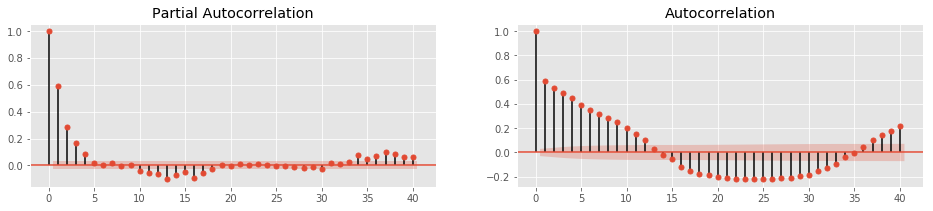

In [108]:
# one pacf and acf
fig, axes = plt.subplots(1, 2, sharex=True,figsize=(16,3))

plot_pacf(df_train.Actual, lags=40, ax=axes[0])
plot_acf(df_train.Actual,lags=40, ax=axes[ 1])

plt.show()

In [127]:
# arima (2,1,1)
from statsmodels.tsa.arima_model import ARIMA

model0 = ARIMA(df_train, order=(1,0,1))
model_fit0 = model0.fit(disp=0)
print(model_fit0.summary())

                              ARMA Model Results                              
Dep. Variable:                 Actual   No. Observations:                 4368
Model:                     ARMA(1, 1)   Log Likelihood              -22757.528
Method:                       css-mle   S.D. of innovations             44.302
Date:                Wed, 19 Aug 2020   AIC                          45523.057
Time:                        20:06:17   BIC                          45548.585
Sample:                    12-23-2019   HQIC                         45532.065
                         - 03-22-2020                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           27.3007      3.205      8.517      0.000      21.018      33.583
ar.L1.Actual     0.9036      0.009    103.077      0.000       0.886       0.921
ma.L1.Actual    -0.5383      0.017    -32.48

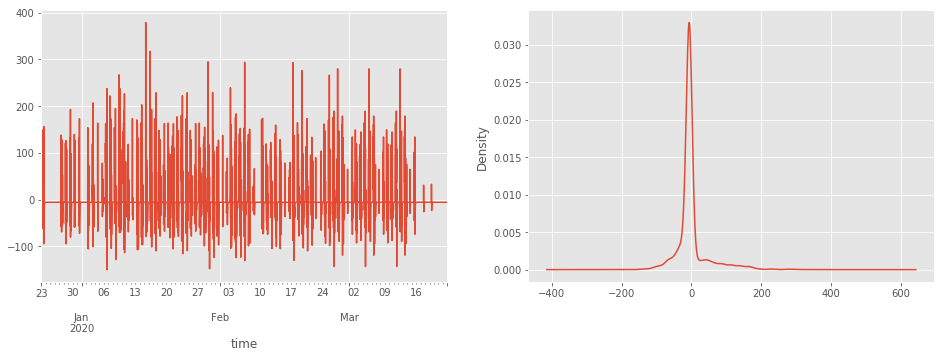

In [128]:
fig, axes = plt.subplots(1, 2, figsize=(16,5))
model_fit0.resid.plot(ax=axes[0])
model_fit0.resid.plot(kind='kde', ax=axes[1])

In [129]:
# predict the model
predict_train= model_fit0.predict(dynamic=False)
#predict_test = model_fit0.predict(df_test.index[0],df_test.index[-1],dynamic=True)

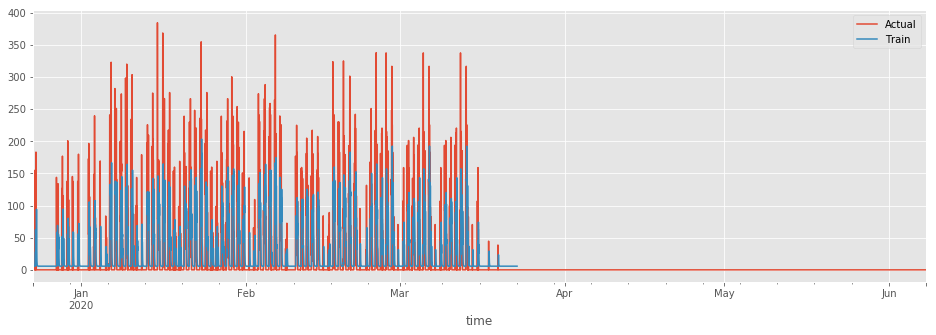

In [130]:
time_index = pd.date_range(start='12/23/2019 00:00:00', end='6/07/2020 23:30:00', freq='30T')
df_model_train= pd.DataFrame(predict_train, columns=({'Train'})).set_index(time_index[3:int(subset_num*size+3)])
#df_model_test= pd.DataFrame(predict_test, columns=({'Test'})).set_index(time_index[3+int(subset_num*size):subset_num+3])
#df_model_simu= pd.DataFrame(predict_simul, columns=({'Prediction'})).set_index(time_index[6451:])

df_all=pd.concat([df_half, df_model_train], axis=1)
#df_sub_pred = df_predict.merge(df_predict,left_on='time',right_on='time')



# plot the result
df_all.set_index(df_all.index).plot(figsize=(16,5))

In [131]:
# next hour prediction
next_halfhour=model_fit0.forecast(steps=1, exog=None, alpha=0.05)

print('Pred: ',next_halfhour[0],'Std: ',next_halfhour[1],'Confidence: ', next_halfhour[2])
print('Actual: ',df_half['Actual'][4368:4369])

Pred:  [5.69868648] Std:  [44.30234364] Confidence:  [[-81.1323115   92.52968445]]
Actual:  time
2020-03-23    0.0
Freq: 30T, Name: Actual, dtype: float64


In [132]:
mae = np.mean(np.abs(df_all['Train'][:4368] - df_all['Actual'][:4368]))
rmse = np.mean((df_all['Train'][:4368] - df_all['Actual'][:4368])**2)**.5

print('MAE: ', mae, 'RMSE: ',rmse)

MAE:  28.76338149988648 RMSE:  52.02153046632511


## decom

In [145]:
from statsmodels.tsa.seasonal import seasonal_decompose
# decompose seasonal 
decom = seasonal_decompose(df_half['Actual'], model='addicative', extrapolate_trend='freq', freq=336)
#decom1 = seasonal_decompose(df_half['Actual'], model='addicative', extrapolate_trend='freq', freq=48)
deseason = df_half.Actual.values - decom.seasonal 
deseason = pd.DataFrame(deseason)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [146]:
deseason.rename(columns=({'seasonal':'Actual'}),inplace=True)
deseason

,Actual
time,
2019-12-23 00:00:00,14.908956
2019-12-23 00:30:00,14.909699
2019-12-23 01:00:00,14.910557
2019-12-23 01:30:00,14.911009
2019-12-23 02:00:00,14.912041
...,...
2020-06-07 21:30:00,14.797624
2020-06-07 22:00:00,14.798029
2020-06-07 22:30:00,14.797798


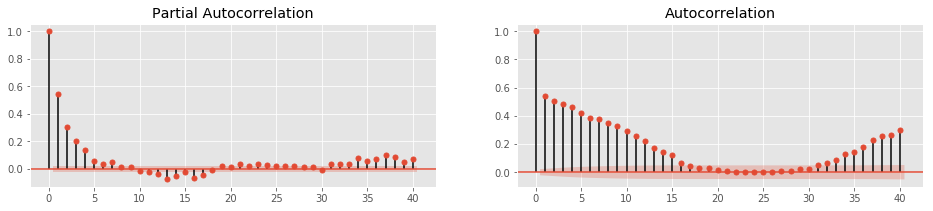

In [147]:
# one pacf and acf
fig, axes = plt.subplots(1, 2, sharex=True,figsize=(16,3))

plot_pacf(deseason.Actual, lags=40, ax=axes[0])
plot_acf(deseason.Actual,lags=40, ax=axes[ 1])

plt.show()

In [148]:
# test stationary
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(deseason.Actual, regression ='ctt')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -9.895477
p-value: 0.000000
Critial Values:
   1%, -4.372574209231234
Critial Values:
   5%, -3.833125923487515
Critial Values:
   10%, -3.553715993569947


In [149]:
# subset 80% of dataset for train and test, 20% for prediction
subset_num = 4368
df_train_test = deseason[['Actual']][:subset_num]
df_simul = deseason[['Actual']][subset_num:]

In [150]:
size=1
df_train= df_train_test [:int(subset_num*size)]
df_test= df_train_test [int(subset_num*size):]
print(len(df_train),len(df_test))


4368 0


In [157]:
#train 
model0 = ARIMA(df_train, order=(3,0,3))
model_fit0 = model0.fit(disp=0)
print(model_fit0.summary())

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                              ARMA Model Results                              
Dep. Variable:                 Actual   No. Observations:                 4368
Model:                     ARMA(3, 3)   Log Likelihood              -22036.987
Method:                       css-mle   S.D. of innovations             37.557
Date:                Wed, 19 Aug 2020   AIC                          44089.973
Time:                        20:23:14   BIC                          44141.030
Sample:                    12-23-2019   HQIC                         44107.991
                         - 03-22-2020                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           27.5182      3.831      7.184      0.000      20.010      35.026
ar.L1.Actual     2.9658      0.001   3664.251      0.000       2.964       2.967
ar.L2.Actual    -2.9485      0.001  -1973.94

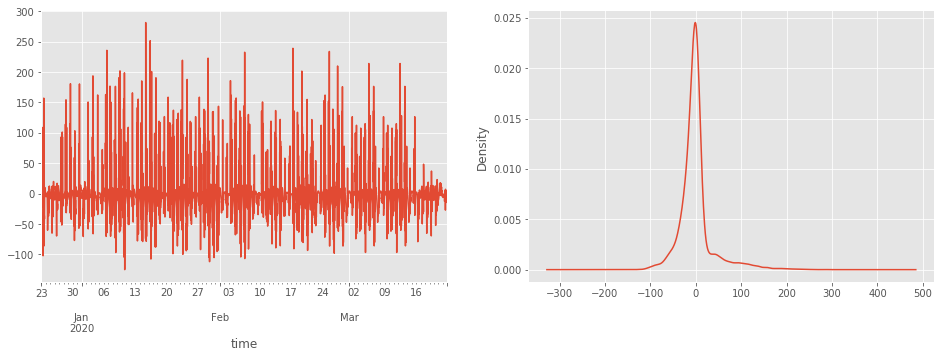

In [158]:
fig, axes = plt.subplots(1, 2, figsize=(16,5))
model_fit0.resid.plot(ax=axes[0])
model_fit0.resid.plot(kind='kde', ax=axes[1])

In [159]:
# predict the model
predict_train= model_fit0.predict(dynamic=False)
#predict_test = model_fit0.predict(df_test.index[0],df_test.index[-1],dynamic=True)

Text(0, 0.5, 'Wh')

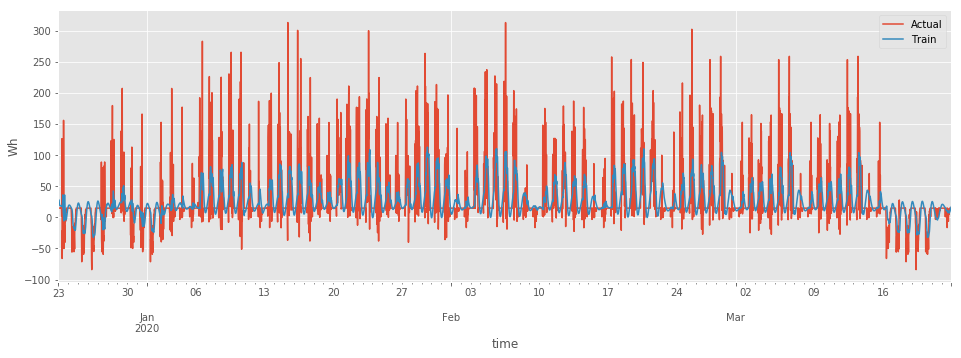

In [168]:
time_index = pd.date_range(start='12/23/2019 00:00:00', end='6/07/2020 23:30:00', freq='30T')
df_model_train= pd.DataFrame(predict_train, columns=({'Train'})).set_index(time_index[3:int(subset_num*size+3)])
#df_model_test= pd.DataFrame(predict_test, columns=({'Test'})).set_index(time_index[3+int(subset_num*size):subset_num+3])
#df_model_simu= pd.DataFrame(predict_simul, columns=({'Prediction'})).set_index(time_index[6451:])

df_all=pd.concat([deseason, df_model_train], axis=1)
#df_sub_pred = df_predict.merge(df_predict,left_on='time',right_on='time')



# plot the result
df_all[:4368].set_index(df_all[:4368].index).plot(figsize=(16,5))
plt.ylabel('Wh')

In [161]:
# next hour prediction
next_halfhour=model_fit0.forecast(steps=1, exog=None, alpha=0.05)

print('Pred: ',next_halfhour[0],'Std: ',next_halfhour[1],'Confidence: ', next_halfhour[2])
print('Actual: ',deseason['Actual'][4368:4369])

Pred:  [18.44998905] Std:  [37.55734822] Confidence:  [[-55.16106081  92.06103891]]
Actual:  time
2020-03-23    14.908956
Freq: 30T, Name: Actual, dtype: float64


In [162]:
predict_next = model_fit0.predict(deseason.index[3],deseason.index[-1],dynamic=True)
next_halfhour = predict_next[4365:4366]
next_halfhour

2020-03-23    27.518175
Freq: 30T, dtype: float64

In [163]:
df_half[4368:4369]

,Actual
time,
2020-03-23,0.0


In [164]:
mae = np.mean(np.abs(df_all['Actual'][:subset_num] - df_all['Train'][:subset_num]))
rmse = np.mean((df_all['Actual'][:subset_num] - df_all['Train'][:subset_num])**2)**.5

print('MAE: ', mae, 'RMSE: ',rmse)

MAE:  23.285430137593174 RMSE:  39.21408666972091


In [165]:
df_all['Actual'][:4368].mean()

27.403975673103503

In [167]:
# without lockdown
mad_mean_ratio =23.285*4368/df_all['Actual'][:4368].sum() 
mad_mean_ratio

0.849694229689955

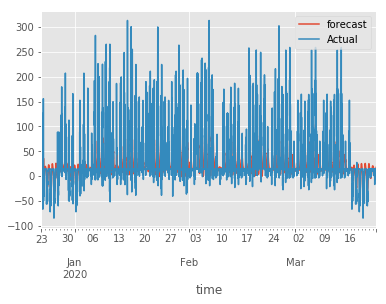

In [203]:
model_fit0.plot_predict(dynamic=False)
plt.show()

In [199]:
ori= model_fit0.predict(df_half.index[6],df_half.index[-1],dynamic=True)
ori1= model_fit0.predict(deseason.index[6],deseason.index[-1],dynamic=True)
ori2=model_fit0.predict(ttt.index[6],ttt.index[-1],dynamic=True)

In [201]:
print(ori[1:2],ori1[1:2],ori2[1:2])

2019-12-23 03:30:00    18.915339
Freq: 30T, dtype: float64 2019-12-23 03:30:00    18.915339
Freq: 30T, dtype: float64 2019-12-23 03:30:00    18.915339
Freq: 30T, dtype: float64


In [210]:
pd.set_option('display.max_rows', None)
df_half[:500]

,Actual
time,
2019-12-23 00:00:00,0.000000
2019-12-23 00:30:00,0.000000
2019-12-23 01:00:00,0.000000
2019-12-23 01:30:00,0.000000
2019-12-23 02:00:00,0.000000
2019-12-23 02:30:00,0.000000
2019-12-23 03:00:00,0.000000
2019-12-23 03:30:00,0.000000
2019-12-23 04:00:00,0.000000
